Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.412724
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.021973
Minibatch accuracy: 75.0%
Validation accuracy: 71.2%
Minibatch loss at step 200: 0.880527
Minibatch accuracy: 62.5%
Validation accuracy: 77.2%
Minibatch loss at step 300: 0.332548
Minibatch accuracy: 93.8%
Validation accuracy: 79.4%
Minibatch loss at step 400: 0.268372
Minibatch accuracy: 93.8%
Validation accuracy: 80.4%
Minibatch loss at step 500: 0.619886
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 600: 0.294765
Minibatch accuracy: 93.8%
Validation accuracy: 81.3%
Minibatch loss at step 700: 0.676115
Minibatch accuracy: 75.0%
Validation accuracy: 81.8%
Minibatch loss at step 800: 0.550055
Minibatch accuracy: 81.2%
Validation accuracy: 82.6%
Minibatch loss at step 900: 0.656155
Minibatch accuracy: 81.2%
Validation accuracy: 83.3%
Minibatch loss at step 1000: 0.388092
Minibatch accuracy: 87.5%
Validation accuracy: 82.9%


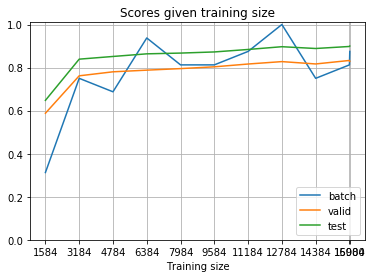

In [6]:
num_steps = 1001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      batch_score = accuracy(predictions, batch_labels)
      valid_score = accuracy(valid_prediction.eval(), valid_labels)
      test_score = accuracy(test_prediction.eval(), test_labels)
      if (step % 100 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % batch_score)
        print('Validation accuracy: %.1f%%' % valid_score)
    result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
  print('Test accuracy: %.1f%%' % test_score)

"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(value=conv, ksize=[1, 5, 5, 1], strides=[1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(value=conv, ksize=[1, 5, 5, 1], strides=[1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 4.459098
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.293338
Minibatch accuracy: 50.0%
Validation accuracy: 52.5%
Minibatch loss at step 200: 0.911436
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%
Minibatch loss at step 300: 0.364862
Minibatch accuracy: 87.5%
Validation accuracy: 81.5%
Minibatch loss at step 400: 0.200448
Minibatch accuracy: 100.0%
Validation accuracy: 81.2%
Minibatch loss at step 500: 0.506912
Minibatch accuracy: 81.2%
Validation accuracy: 82.4%
Minibatch loss at step 600: 0.451401
Minibatch accuracy: 87.5%
Validation accuracy: 82.7%
Minibatch loss at step 700: 0.991886
Minibatch accuracy: 68.8%
Validation accuracy: 84.0%
Minibatch loss at step 800: 0.488488
Minibatch accuracy: 87.5%
Validation accuracy: 84.5%
Minibatch loss at step 900: 0.598706
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.342128
Minibatch accuracy: 87.5%
Validation accuracy: 84.8%

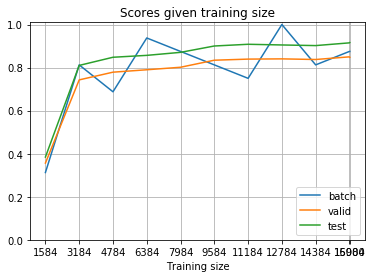

In [8]:
num_steps = 1001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      batch_score = accuracy(predictions, batch_labels)
      valid_score = accuracy(valid_prediction.eval(), valid_labels)
      test_score = accuracy(test_prediction.eval(), test_labels)
      if (step % 100 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % batch_score)
        print('Validation accuracy: %.1f%%' % valid_score)
    result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
  print('Test accuracy: %.1f%%' % test_score)

"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [5]:
batch_size = 256
patch_size = 5
depthC1 = 20
depthC2 = 50
num_hidden = 100
drop_prob = 0.8

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depthC1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depthC1]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depthC1, depthC2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depthC2]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depthC2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.dropout(tf.nn.max_pool(tf.nn.relu(conv + layer1_biases), 
                                          ksize=[1, 2, 2, 1], 
                                          strides=[1, 2, 2, 1], 
                                          padding='SAME'), drop_prob)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.dropout(tf.nn.max_pool(tf.nn.relu(conv + layer2_biases), 
                                          ksize=[1, 2, 2, 1], 
                                          strides=[1, 2, 2 ,1], 
                                          padding='SAME'), drop_prob)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.2, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 8.560931
Minibatch accuracy: 10.2%
Validation accuracy: 11.4%
Minibatch loss at step 1000: 0.341154
Minibatch accuracy: 89.1%
Validation accuracy: 85.3%
Minibatch loss at step 2000: 0.379335
Minibatch accuracy: 87.9%
Validation accuracy: 87.0%
Minibatch loss at step 3000: 0.432680
Minibatch accuracy: 86.7%
Validation accuracy: 87.7%
Minibatch loss at step 4000: 0.357620
Minibatch accuracy: 90.2%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.421621
Minibatch accuracy: 87.9%
Validation accuracy: 88.8%
Minibatch loss at step 6000: 0.369470
Minibatch accuracy: 87.5%
Validation accuracy: 89.3%
Minibatch loss at step 7000: 0.270961
Minibatch accuracy: 92.6%
Validation accuracy: 89.7%
Minibatch loss at step 8000: 0.281513
Minibatch accuracy: 90.6%
Validation accuracy: 89.6%
Minibatch loss at step 9000: 0.335236
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%
Minibatch loss at step 10000: 0.252783
Minibatch accuracy: 92.6%
Validation accur

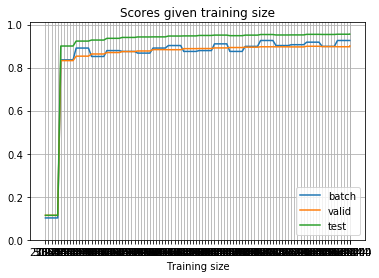

In [6]:
num_steps = 10001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      batch_score = accuracy(predictions, batch_labels)
      valid_score = accuracy(valid_prediction.eval(), valid_labels)
      test_score = accuracy(test_prediction.eval(), test_labels)
      if (step % 1000 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % batch_score)
        print('Validation accuracy: %.1f%%' % valid_score)
    result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
  print('Test accuracy: %.1f%%' % test_score)

"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

* Batch size: 64
* patch_size = 5
* depthC1 = 20
* depthC2 = 50
* num_hidden = 100

Minibatch loss at step 10000: 0.049425
Minibatch accuracy: 100.0%
Validation accuracy: 87.4%
Test accuracy: 93.9%

* Batch size: 256
* patch_size = 5
* depthC1 = 20
* depthC2 = 50
* num_hidden = 100

Minibatch loss at step 10000: 0.252783
Minibatch accuracy: 92.6%
Validation accuracy: 90.0%
Test accuracy: 95.5%